In [88]:
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.stats import linregress
import numpy as np
from sklearn import datasets
import pandas as pd
from config import api_key
import requests
import json
from datetime import datetime
%matplotlib inline
import scipy.stats as stats

In [3]:
tickers = ["AAPL", "GOOG", "AMZN"]

dummy = pd.DataFrame(columns = ["ticker", "o", "c", "t"])

#create loop to run through URL & save info into lists
for name in tickers:
    base_url = f"https://api.polygon.io/v2/aggs/ticker/{name}/range/1/day/2012-01-01/2022-10-24?adjusted=true&sort=asc&limit=50000&apiKey={api_key}"
    response = requests.get(base_url).json()
    datadata = pd.json_normalize(response["results"])
    datadata["ticker"] = name
    datadata = datadata[["ticker", "o", "c", "t"]]

#print(datadata)
    dummy = pd.concat([dummy,datadata])
dummy.columns=["ticker", "open", "close", "date"]

#pd.concat([dummy,datadata],axis=0)
print(dummy.head())


  ticker     open    close           date
0   AAPL  21.2818  20.6000  1351828800000
1   AAPL  20.8398  20.8793  1352091600000
2   AAPL  21.0796  20.8161  1352178000000
3   AAPL  20.4941  19.9286  1352264400000
4   AAPL  20.0225  19.2054  1352350800000


In [4]:
#Print types
dummy.info()
#Convert unix to datetime & remove hours/miuntes
dummy['date'] = pd.to_datetime(dummy['date'],unit='ms')
dummy["date"] = pd.to_datetime(dummy["date"]).dt.date
#dummy.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7533 entries, 0 to 2510
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ticker  7533 non-null   object 
 1   open    7533 non-null   float64
 2   close   7533 non-null   float64
 3   date    7533 non-null   object 
dtypes: float64(2), object(2)
memory usage: 294.3+ KB


In [5]:
#Create copy of dummy
tickers_copy = dummy.copy(deep=True)
#delete
del tickers_copy["open"]
#tickers_copy
#Create copy of dummy for %change & $change
tickers_pctchange = tickers_copy.copy(deep=True)


#Divide dataframes into new dataframes by ticker
aapl_daily2 = tickers_pctchange[tickers_pctchange["ticker"] == "AAPL"]
aapl_daily2 = pd.DataFrame(aapl_daily2)
#print(aapl_daily2.head())
amzn_daily2 = tickers_pctchange[tickers_pctchange["ticker"] == "AMZN"]
amzn_daily2 = pd.DataFrame(amzn_daily2)
#print(amzn_daily2.head())
goog_daily2 = tickers_pctchange[tickers_pctchange["ticker"] == "GOOG"]
goog_daily2 = pd.DataFrame(goog_daily2)
#print(goog_daily2.head())

#rename close as ticker to prepare to merge by date
aapl_daily2.rename(columns = {'close':'AAPL'}, inplace = True)
del aapl_daily2["ticker"]
amzn_daily2.rename(columns = {'close':'AMZN'}, inplace = True)
del amzn_daily2["ticker"]
goog_daily2.rename(columns = {'close':'GOOG'}, inplace = True)
del goog_daily2["ticker"]

#make copy for prices 
aapl_prices = aapl_daily2.copy(deep=True)
amzn_prices = amzn_daily2.copy(deep=True)
goog_prices = goog_daily2.copy(deep=True)
print(aapl_prices)

#make copy for $ changes
aapl_bch = aapl_daily2.copy(deep=True)
amzn_bch = amzn_daily2.copy(deep=True)
goog_bch = goog_daily2.copy(deep=True)
#print(goog_bch)

#calculate % change
aapl_daily2["AAPL"]=aapl_daily2["AAPL"].pct_change()*100
amzn_daily2["AMZN"]=amzn_daily2["AMZN"].pct_change()*100
goog_daily2["GOOG"]=goog_daily2["GOOG"].pct_change()*100
aapl_daily2 = aapl_daily2[["date", "AAPL"]]
#calculate $ change
aapl_bch["AAPL"]=aapl_bch["AAPL"].diff()
amzn_bch["AMZN"]=amzn_bch["AMZN"].diff()
goog_bch["GOOG"]=goog_bch["GOOG"].diff()
amzn_bch.head()
#aapl_daily2

          AAPL        date
0      20.6000  2012-11-02
1      20.8793  2012-11-05
2      20.8161  2012-11-06
3      19.9286  2012-11-07
4      19.2054  2012-11-08
...        ...         ...
2506  143.7500  2022-10-18
2507  143.8600  2022-10-19
2508  143.3900  2022-10-20
2509  147.2700  2022-10-21
2510  149.4500  2022-10-24

[2511 rows x 2 columns]


,AMZN,date
0,NaN,2012-11-02
1,0.0954,2012-11-05
2,0.1615,2012-11-06
3,-0.2750,2012-11-07
4,-0.2355,2012-11-08


In [101]:
#merge tables % change
merge_pctchange = aapl_daily2.merge(amzn_daily2, on='date', how='left')
merge_pctchange = merge_pctchange.merge(goog_daily2, on="date", how="left")
#merge_pctchange.head()

#merge tables prices 
merge_prices = aapl_prices.merge(amzn_prices, on='date', how='left')
merge_prices = merge_prices.merge(goog_prices, on="date", how="left")

#merge tables $change
merge_bch = aapl_bch.merge(amzn_bch, on='date', how='left')
merge_bch = merge_bch.merge(goog_bch, on="date", how="left")
merge_bch.head()

#reorder columns
merge_pctchange= merge_pctchange[['date','AAPL','GOOG', "AMZN"]]
merge_prices= merge_prices[['date','AAPL','GOOG', "AMZN"]]
merge_bch= merge_bch[['date','AAPL','GOOG', "AMZN"]]
#merge_prices

NameError: name 'ax_hist_aapl_y' is not defined

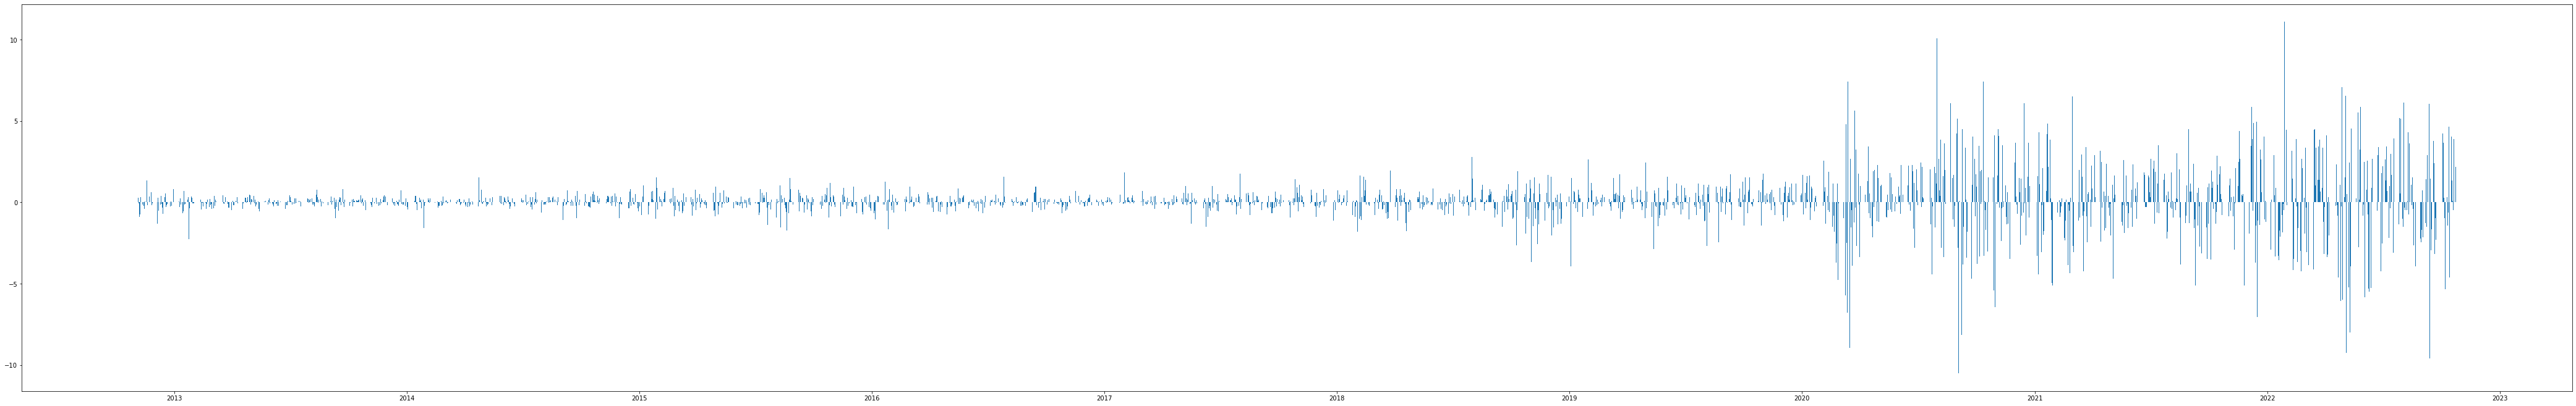

In [7]:

#Creating & plotting scatter/histogram for % &$ distribution
fig= plt.figure(figsize=(100,200))
gs=plt.GridSpec(32,4)

#AAPL subplots
ax_aapl_bar_z=fig.add_subplot(gs[0:2, 0:3])
ax_aapl_bar_z.bar(aapl_bch["date"], aapl_bch["AAPL"], align='center')
ax_hist_aapl_y=fig.add_subplot(gs[2:4,0:3],  sharey=ax_hist_aapl_y)
ax_hist_aapl_y.hist(aapl_prices["AAPL"])
ax_scatter_aapl=fig.add_subplot(gs[4:8, 0:3])
ax_scatter_aapl.scatter(aapl_daily2["date"], aapl_daily2["AAPL"])
ax_hist_aapl_x=fig.add_subplot(gs[4:8,3])
ax_hist_aapl_x.hist(aapl_daily2["AAPL"], orientation="horizontal")
#add AMZN subplots
ax_amzn_bar=fig.add_subplot(gs[8:10, 0:3])
ax_amzn_bar.bar(amzn_bch["date"], amzn_bch["AMZN"], align='center')
ax_hist_amzn_y=fig.add_subplot(gs[10:12,0:3])
ax_hist_amzn_y.hist(amzn_prices["AMZN"])
ax_scatter_amzn=fig.add_subplot(gs[12:16, 0:3])
ax_scatter_amzn.scatter(amzn_daily2["date"], amzn_daily2["AMZN"])
ax_hist_amzn_x=fig.add_subplot(gs[12:16,3])
ax_hist_amzn_x.hist(amzn_daily2["AMZN"], orientation="horizontal")
#add GOOGL subplots
ax_goog_bar=fig.add_subplot(gs[16:20, 0:3])
ax_goog_bar.bar(goog_bch["date"], goog_bch["GOOG"], align='center')
ax_hist_goog_y=fig.add_subplot(gs[20:24,0:3])
ax_hist_goog_y.hist(goog_prices["GOOG"])
ax_scatter_goog=fig.add_subplot(gs[24:32, 0:3])
ax_scatter_goog.scatter(goog_daily2["date"], goog_daily2["GOOG"])
ax_hist_goog_x=fig.add_subplot(gs[24:32,3])
ax_hist_goog_x.hist(goog_daily2["GOOG"], 40,orientation="horizontal")
plt.show()


In [ ]:
#Creating & plotting scatter/histogram for % &$ distribution
fig= plt.figure(figsize=(45,30))
#fig, ax = plt.subplots(3, 2, figsize=(45,30))
gs=GridSpec(8,4,wspace=0.4, hspace=0.3)
ax_aapl_bar_z=fig.add_subplot(gs[0:2, 0:3])
ax_aapl_hist_y=fig.add_subplot(gs[2:4,0:3])
ax_scatter=fig.add_subplot(gs[4:8, 0:3])
ax_hist_x=fig.add_subplot(gs[4:8,3])

ax_hist_x.hist(aapl_daily2["AAPL"], orientation="horizontal")
ax_aapl_bar_z.bar(aapl_bch["date"], aapl_bch["AAPL"], align='center')
ax_scatter.scatter(aapl_daily2["date"], aapl_daily2["AAPL"],  s=5)
ax_aapl_hist_y.hist(aapl_prices["AAPL"])
plt.show()

In [ ]:
#plt.bar(aapl_bch["date"], aapl_bch["AAPL"], align='center')

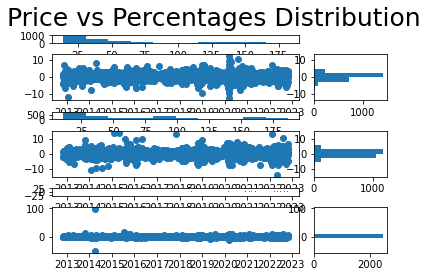

In [125]:
#Creating & plotting scatter/histogram for % &$ distribution
fig= plt.figure()
#fig, ax = plt.subplots(12, 4, figsize=(80,80))
#fig, ax = plt.subplots(sharex=True, sharey=False,figsize=(60,60))
gs=GridSpec(23,4)
plt.suptitle('Price vs Percentages Distribution', fontsize=25)
#AAPL subplots
ax_hist_aapl_y=fig.add_subplot(gs[0:1,0:3])
ax_hist_aapl_y.hist(aapl_prices["AAPL"])
ax_scatter_aapl=fig.add_subplot(gs[2:7, 0:3])
ax_scatter_aapl.scatter(aapl_daily2["date"], aapl_daily2["AAPL"])
ax_hist_aapl_x=fig.add_subplot(gs[2:7,3])
ax_hist_aapl_x.hist(aapl_daily2["AAPL"], orientation="horizontal")
#add AMZN subplots
ax_hist_amzn_y=fig.add_subplot(gs[8:9,0:3])
ax_hist_amzn_y.hist(amzn_prices["AMZN"])
ax_scatter_amzn=fig.add_subplot(gs[10:15, 0:3])
ax_scatter_amzn.scatter(amzn_daily2["date"], amzn_daily2["AMZN"])
ax_hist_amzn_x=fig.add_subplot(gs[10:15,3])
ax_hist_amzn_x.hist(amzn_daily2["AMZN"], orientation="horizontal")
#add GOOGL subplots
ax_hist_goog_y=fig.add_subplot(gs[16:17,0:3])
plt.bar(goog_bch["date"], goog_bch["GOOG"])
ax_scatter_goog=fig.add_subplot(gs[18:23, 0:3])
ax_scatter_goog.scatter(goog_daily2["date"], goog_daily2["GOOG"])

ax_hist_goog_x=fig.add_subplot(gs[18:23,3])
ax_hist_goog_x.hist(goog_daily2["GOOG"], orientation="horizontal")
plt.show()

In [ ]:
#aapl_plot, = plt.plot(merge_pctchange["date"], merge_pctchange["AAPL"], color="blue", label="AAPL" )
#amzn, = plt.plot(merge_pctchange["date"], merge_pctchange["AMZN"], color="red", label="AMZN" )
#goog, = plt.plot(merge_pctchange["date"], merge_pctchange["GOOG"], color="green", label="GOOG" )
#plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002452B73E208>,
      dtype=object)

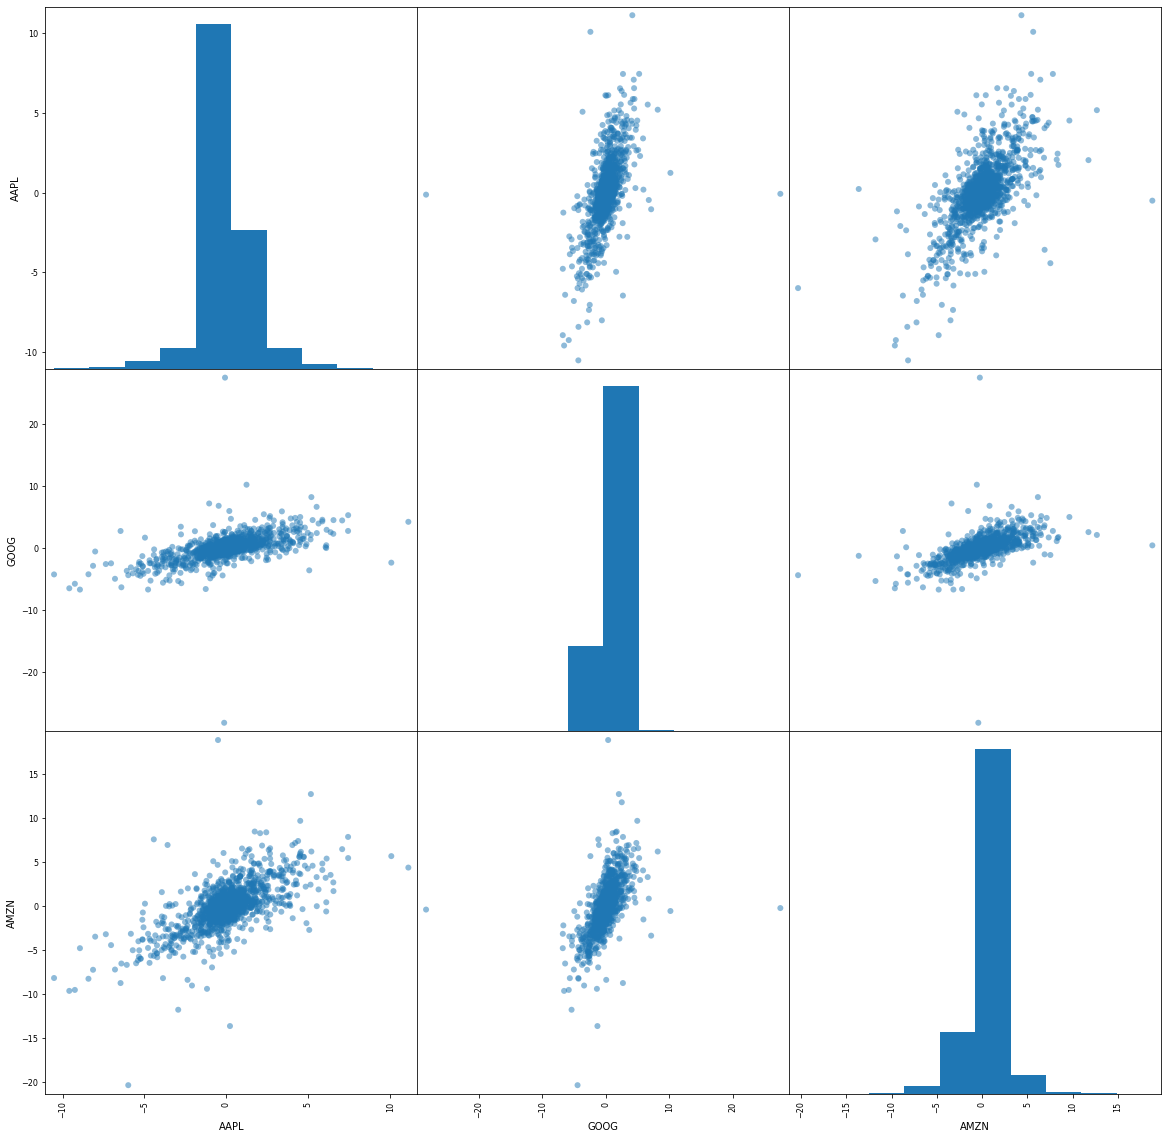

In [103]:
#Create scatter matrix of daily returns by percent

stocks_corr = merge_pctchange.corr()
stocks_corr
pd.plotting.scatter_matrix(merge_bch,figsize=(20,20),grid=True,
                           marker='o')
 

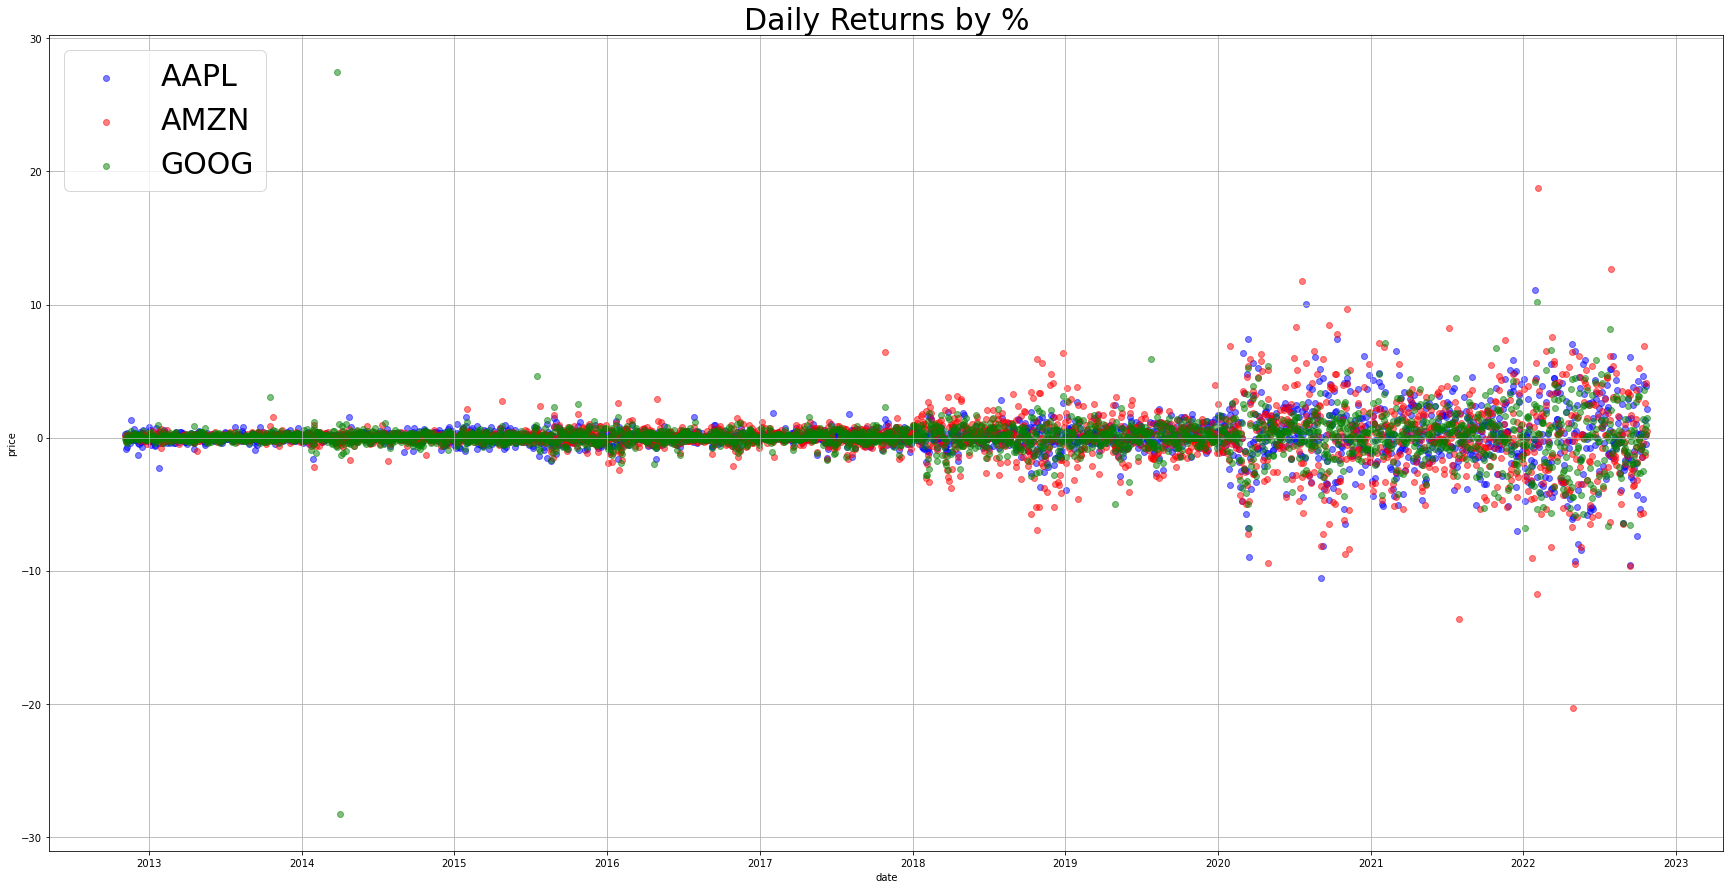

In [118]:
#Create scatterplot of all 3 stocks by daily % change
plt.figure(figsize=(30,15))
plt.scatter(merge_bch["date"], merge_bch["AAPL"], color='blue', label="AAPL", alpha = .5)
plt.scatter(merge_bch["date"], merge_bch["AMZN"], color='red', label="AMZN",  alpha = .5)
plt.scatter(merge_bch["date"], merge_bch["GOOG"], color='green', label="GOOG",  alpha = .5)
plt.grid()
plt.xlabel("date")
plt.ylabel("price")
plt.title("Daily Returns by %", fontsize = 30)
plt.legend(fontsize = "30",loc="upper left")

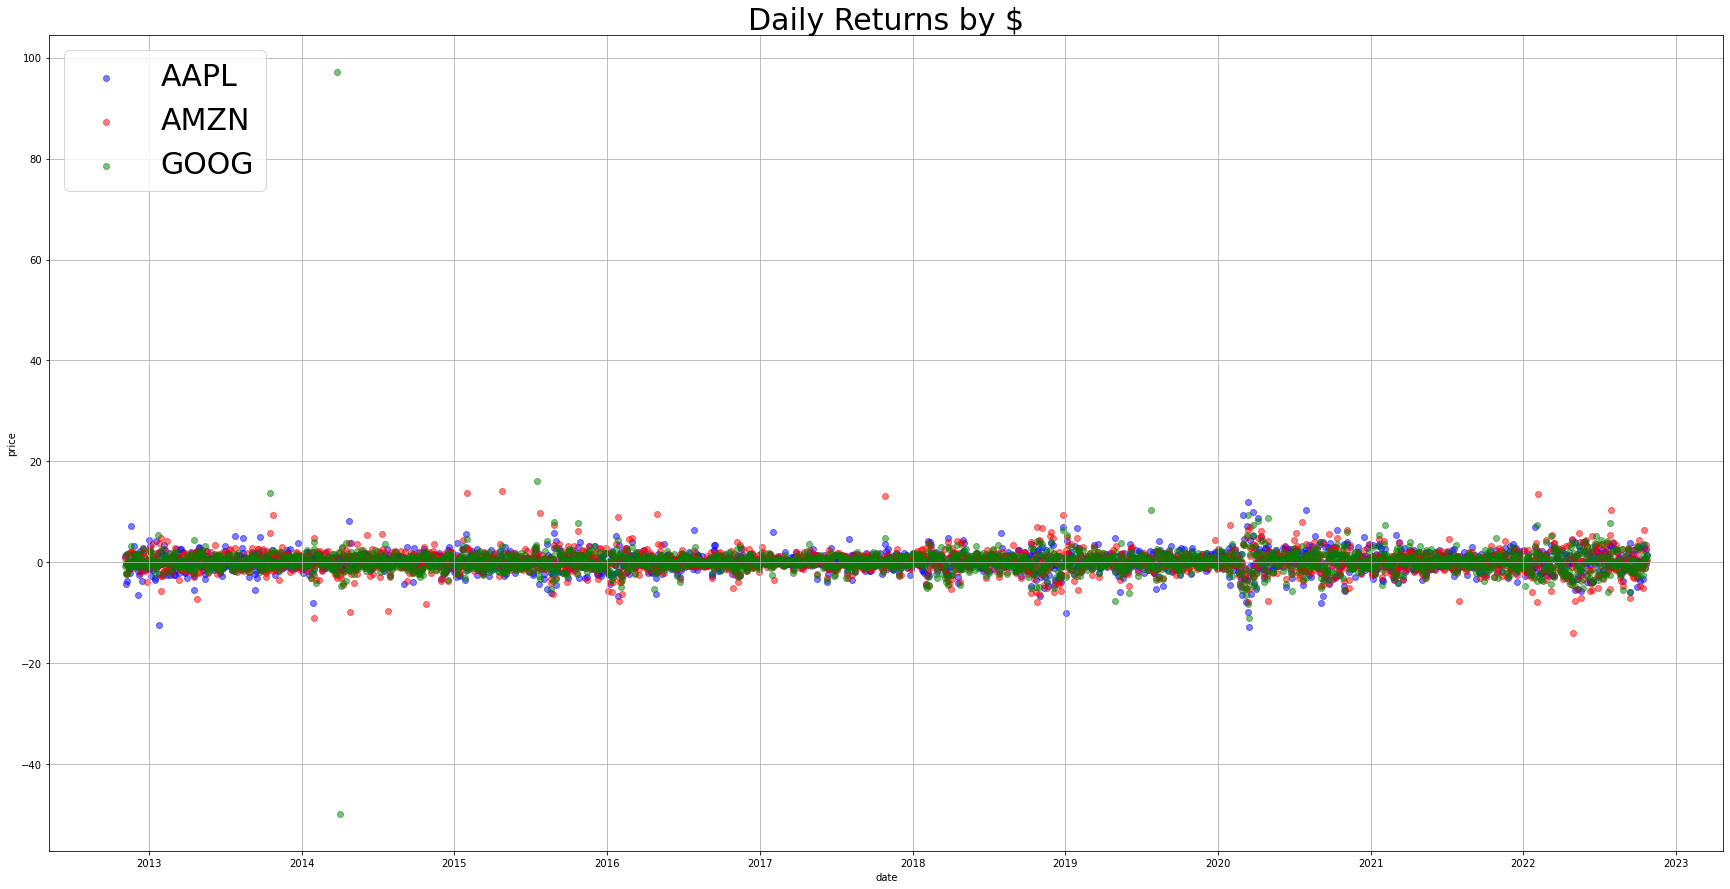

In [119]:
#Create scatterplot of all 3 stocks by daily % change
plt.figure(figsize=(30,15))
plt.scatter(merge_pctchange["date"], merge_pctchange["AAPL"], color='blue', label="AAPL", alpha = .5)
plt.scatter(merge_pctchange["date"], merge_pctchange["AMZN"], color='red', label="AMZN",  alpha = .5)
plt.scatter(merge_pctchange["date"], merge_pctchange["GOOG"], color='green', label="GOOG",  alpha = .5)
plt.grid()
plt.xlabel("date")
plt.ylabel("price")
plt.title("Daily Returns by $", fontsize = 30)
plt.legend(fontsize = "30",loc="upper left")

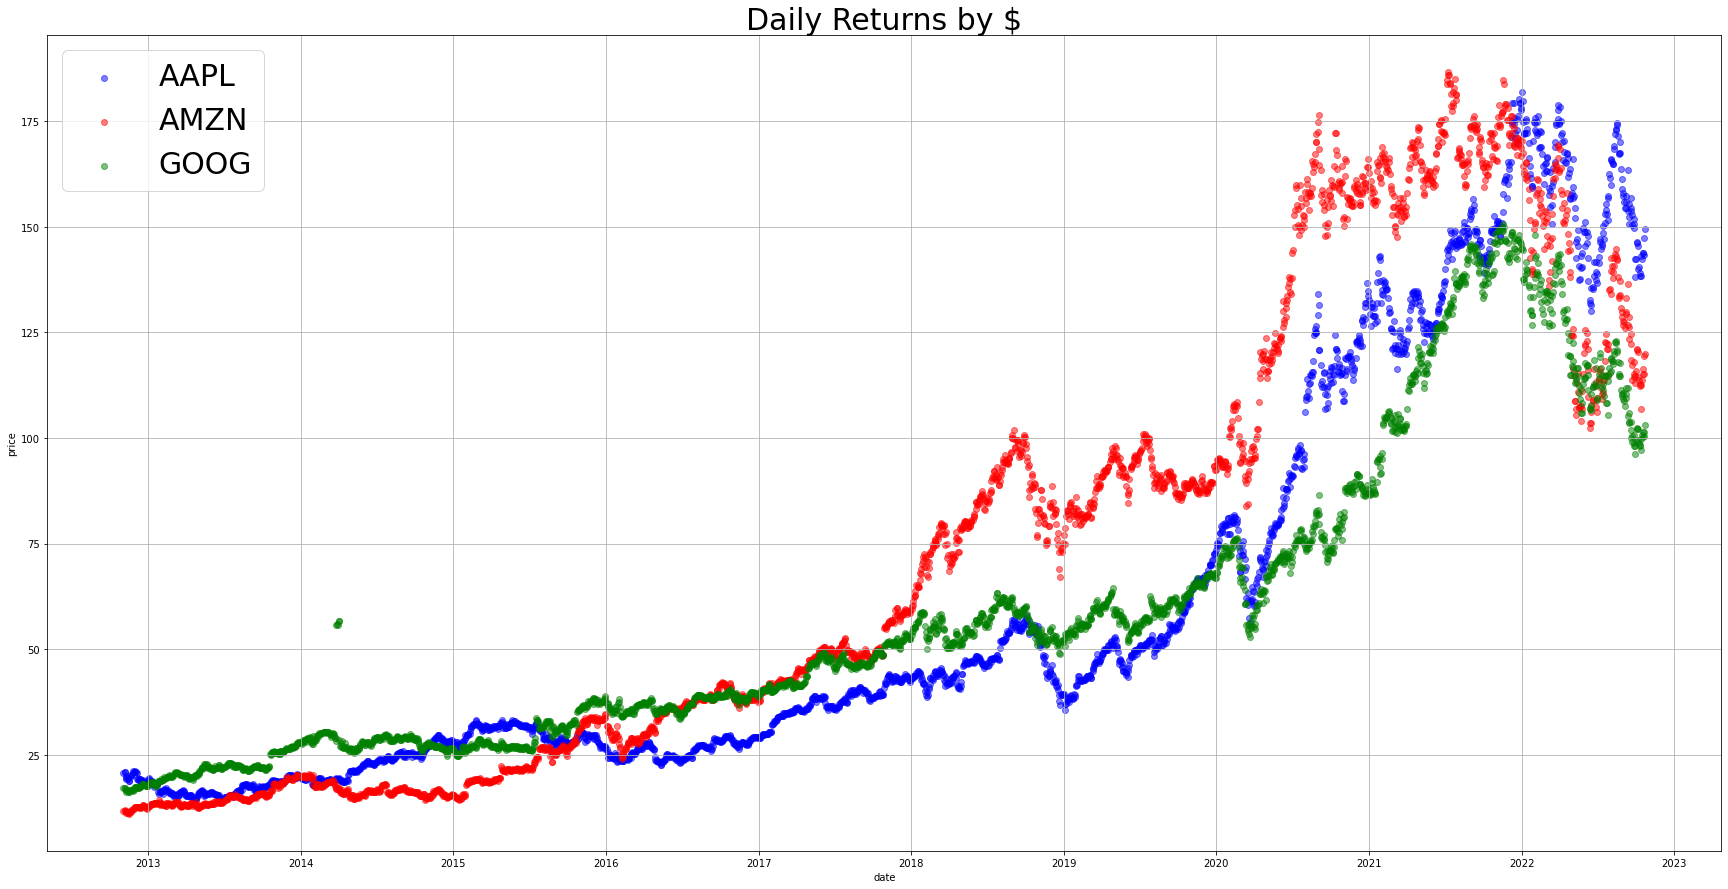

In [120]:
#Create scatterplot of all 3 stocks by daily % change
plt.figure(figsize=(30,15))
plt.scatter(merge_prices["date"], merge_prices["AAPL"], color='blue', label="AAPL", alpha = .5)
plt.scatter(merge_prices["date"], merge_prices["AMZN"], color='red', label="AMZN",  alpha = .5)
plt.scatter(merge_prices["date"], merge_prices["GOOG"], color='green', label="GOOG",  alpha = .5)
plt.grid()
plt.xlabel("date")
plt.ylabel("price")
plt.title("Daily Returns by $", fontsize = 30)
plt.legend(fontsize = "30",loc="upper left")

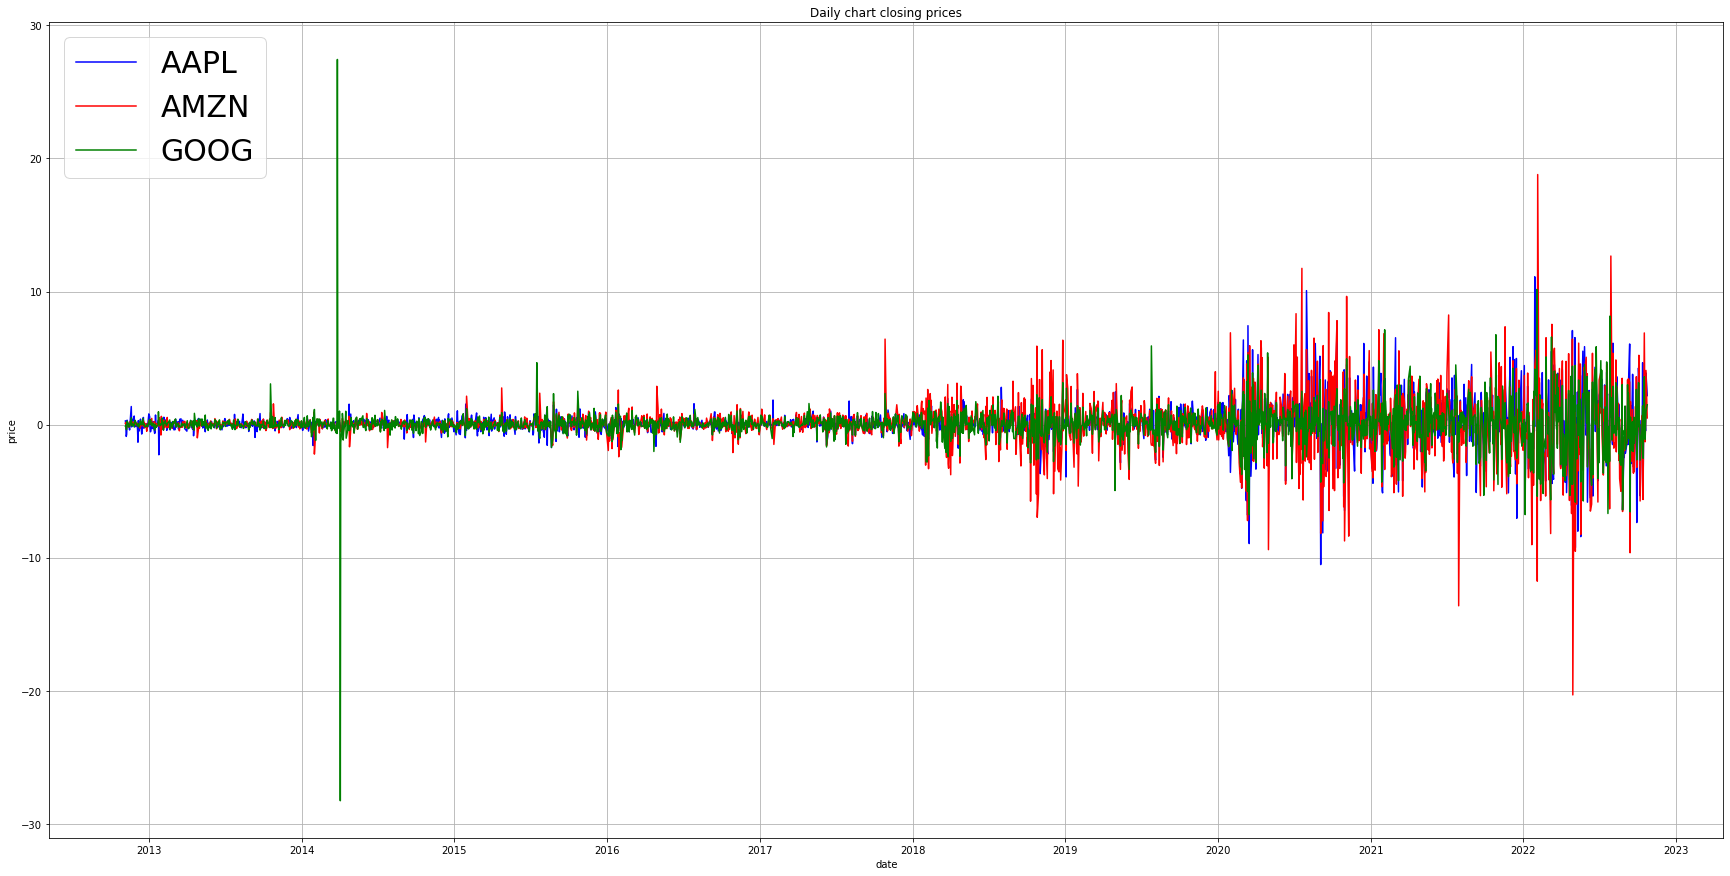

In [110]:
plt.figure(figsize=(30,15))
aapl_daily_chart, = plt.plot(merge_bch["date"], merge_bch["AAPL"], color='blue', label="AAPL")
amzn_daily_chart, = plt.plot(merge_bch["date"], merge_bch["AMZN"], color='red', label="AMZN")
goog_daily_chart, = plt.plot(merge_bch["date"], merge_bch["GOOG"], color='green', label="GOOG")
plt.grid()
plt.xlabel("date")
plt.ylabel("price")
plt.title("Daily chart closing prices")
plt.legend(fontsize = "30",loc="upper left")

In [13]:
pd.set_option('display.max_columns', None)

In [14]:
tickers2 = ["AAPL", "GOOG", "AMZN"]

dum_financials = pd.DataFrame(columns = ["start_date","end_date", "company_name", "fiscal_period", "fiscal_year", 
                                        "financials.income_statement.revenues.value", 
                                        "financials.income_statement.net_income_loss.value", 
                                        "financials.income_statement.gross_profit.value", 
                                        "financials.income_statement.basic_earnings_per_share.value"])

#create loop to run through URL & save info into lists
for name in tickers2:
    base_financials = f"https://api.polygon.io/vX/reference/financials?ticker={name}&timeframe=quarterly&limit=40&sort=period_of_report_date&apiKey={api_key}"
    financials_response = requests.get(base_financials).json()
    datafinancials = pd.json_normalize(financials_response["results"])
#    datafinancials = pd.json_normalize(financials_response, max_level=5, record_path=["results"])
    datafinancials["company_name"] = name

    datafinancials = datafinancials[["start_date","end_date", "company_name", "fiscal_period", "fiscal_year", 
                                        "financials.income_statement.revenues.value", 
                                        "financials.income_statement.net_income_loss.value", 
                                        "financials.income_statement.gross_profit.value", 
                                        "financials.income_statement.basic_earnings_per_share.value"]]
    dum_financials= pd.concat([dum_financials,datafinancials])
dum_financials.columns=["Start Date", "End Date", "Company Name", "Fiscal Period", "Fiscal Year", "Revnue", 
                      "Net Income/Loss", "Gross Profit", "EPS"]
print(dum_financials)


    Start Date    End Date Company Name Fiscal Period Fiscal Year  \
0   2022-03-27  2022-06-25         AAPL            Q3        2022   
1   2021-12-26  2022-03-26         AAPL            Q2        2022   
2   2021-09-26  2021-12-25         AAPL            Q1        2022   
3   2021-03-28  2021-06-26         AAPL            Q3        2021   
4   2020-12-27  2021-03-27         AAPL            Q2        2021   
..         ...         ...          ...           ...         ...   
34  2011-01-01  2011-03-31         AMZN            Q1        2011   
35  2010-04-01  2010-06-30         AMZN            Q2        2010   
36  2010-01-01  2010-03-31         AMZN            Q1        2010   
37  2009-07-01  2009-09-30         AMZN                             
38  2009-04-01  2009-06-30         AMZN                             

          Revnue  Net Income/Loss  Gross Profit   EPS  
0   8.295900e+10     1.944200e+10  3.588500e+10  1.20  
1   9.727800e+10     2.501000e+10  4.255900e+10  1.54  
2  

In [14]:
tickers3 = ["AAPL", "GOOG", "AMZN"]

dum_fiscal_year_is = pd.DataFrame(columns = ["date", "symbol", "fillingDate", "calendarYear", 
                                          "period", "revenue", "grossProfit", "netIncome", 
                                          "eps", "weightedAverageShsOut"])

prep_key = "b4fe65382da39adf450a1bdfc846fd2e"
for name in tickers3:
    query_url = f"https://financialmodelingprep.com/api/v3/income-statement/{name}?limit=12&apikey={prep_key}"
    fiscal_response = requests.get(query_url).json()
    fiscal_year_is = pd.json_normalize(fiscal_response)
    fiscal_year_is["symbol"] = name
    fiscal_year_is = fiscal_year_is[["date", "symbol", "fillingDate", "calendarYear", 
                                "period", "revenue", "grossProfit", "netIncome", 
                                "eps", "weightedAverageShsOut"]]
    dum_fiscal_year_is= pd.concat([dum_fiscal_year_is,fiscal_year_is])
dum_fiscal_year_is.columns=["Date", "Ticker", "Filing Date", "Fiscal Year", "Period", 
                      "Revenue", "Gross Profit", "Net Income", "EPS", "Shares Outstanding"]
#print(dum_fiscal_year_is)
#Create copy that won't affect original
fiscal_years_is = dum_fiscal_year_is.copy(deep=True)

#fiscal_years
#Create separate dataframe based on symbols
aapl_yis = fiscal_years_is[fiscal_years_is["Ticker"] == "AAPL"]
aapl_yis = pd.DataFrame(aapl_yis)
#print(aapl_fiscal_year.head())
amzn_yis = fiscal_years_is[fiscal_years_is["Ticker"] == "AMZN"]
amzn_yis = pd.DataFrame(amzn_yis)
#print(amzn_fiscal_year.head())
goog_yis = fiscal_years_is[fiscal_years_is["Ticker"] == "GOOG"]
goog_yis = pd.DataFrame(goog_yis)
goog_yis.tail()

,Date,Ticker,Filing Date,Fiscal Year,Period,Revenue,Gross Profit,Net Income,EPS,Shares Outstanding
7,2014-12-31,GOOG,2014-12-31,2014,FY,66001000000,40310000000,14444000000,1.068500,13518694592
8,2013-12-31,GOOG,2013-12-31,2013,FY,59825000000,33967000000,12920000000,1.941001,6656917337
9,2012-12-31,GOOG,2012-12-31,2012,FY,50175000000,29541000000,10737000000,1.640501,6544257382
10,2011-12-31,GOOG,2011-12-31,2011,FY,37905000000,24717000000,9737000000,1.508501,6455557417
11,2010-12-31,GOOG,2010-12-31,2010,FY,29321000000,18904000000,8505000000,1.334501,6374037450


In [6]:
tickers3 = ["AAPL", "GOOG", "AMZN"]

dum_fiscal_qis = pd.DataFrame(columns = ["date", "symbol", "fillingDate", "calendarYear", 
                                          "period", "revenue", "grossProfit", "netIncome", 
                                          "eps", "weightedAverageShsOut"])

prep_key = "b4fe65382da39adf450a1bdfc846fd2e"
for name in tickers3:
    query_url = f"https://financialmodelingprep.com/api/v3/income-statement/{name}?period=quarter&limit=400&apikey={prep_key}"
    fiscal_response = requests.get(query_url).json()
    fiscal_yearqis = pd.json_normalize(fiscal_response)
    fiscal_yearqis["symbol"] = name
    fiscal_yearqis = fiscal_yearqis[["date", "symbol", "fillingDate", "calendarYear", 
                                "period", "revenue", "grossProfit", "netIncome", 
                                "eps", "weightedAverageShsOut"]]
    dum_fiscal_yearqis= pd.concat([dum_fiscal_qis,fiscal_yearqis])
dum_fiscal_yearqis.columns=["Date", "Ticker", "Filing Date", "Fiscal Year", "Period", 
                      "Revenue", "Gross Profit", "Net Income", "EPS", "Shares Outstanding"]
#print(dum_fiscal_yearqis)
#Create copy that won't affect original
fiscal_yearsqis = dum_fiscal_yearqis.copy(deep=True)
fiscal_yearsqis
#fiscal_years
#Create separate dataframe based on symbols
#aapl_qis = fiscal_yearsqis[fiscal_yearsqis["Ticker"] == "AAPL"]
#aapl_qis = pd.DataFrame(aapl_qis)
#print(aapl_fiscal_year.head())
#amzn_qis = fiscal_yearsqis[fiscal_yearsqis["Ticker"] == "AMZN"]
#amzn_qis = pd.DataFrame(amzn_qis)
#print(amzn_fiscal_year.head())
#goog_qis = fiscal_yearqis[fiscal_yearqis["Ticker"] == "GOOG"]
#goog_qis = pd.DataFrame(goog_qis)
dum_fiscal_yearqis

,Date,Ticker,Filing Date,Fiscal Year,Period,Revenue,Gross Profit,Net Income,EPS,Shares Outstanding
0,2022-09-30,AMZN,2022-10-28,2022,Q3,1.271010e+11,3.625000e+10,2.872000e+09,0.280000,10191000000
1,2022-06-30,AMZN,2022-07-29,2022,Q2,1.212340e+11,1.639600e+10,-2.028000e+09,-0.200000,10175000000
2,2022-03-31,AMZN,2022-04-29,2022,Q1,1.164440e+11,1.483200e+10,-3.844000e+09,-0.377603,10180000000
3,2021-12-31,AMZN,2022-02-04,2021,Q4,1.374120e+11,1.681900e+10,1.432300e+10,1.410500,10160000000
4,2021-09-30,AMZN,2021-10-29,2021,Q3,1.108120e+11,2.938400e+10,3.156000e+09,0.306408,10140000000
...,...,...,...,...,...,...,...,...,...,...
102,1997-03-31,AMZN,1997-03-31,1997,Q1,1.600000e+07,4.200000e+06,-3.000000e+06,-0.000523,5731880000
103,1996-12-31,AMZN,1996-12-31,1996,Q4,8.400000e+06,0.000000e+00,-2.300000e+06,-0.000401,5731880000
104,1996-09-30,AMZN,1996-09-30,1996,Q3,4.200000e+06,0.000000e+00,-2.400000e+06,-0.000500,4800000000
105,1996-06-30,AMZN,1996-06-30,1996,Q2,2.200000e+06,0.000000e+00,-8.000000e+05,-0.000500,1600000000


In [20]:
tickers3 = ["AAPL", "GOOG", "AMZN"]

dum_fiscal_ybs = pd.DataFrame(columns = ["date", "symbol", "fillingDate", "calendarYear", 
                                          "period", "cashAndCashEquivalents", "shortTermDebt", "longTermDebt"])

prep_key = "b4fe65382da39adf450a1bdfc846fd2e"
for name in tickers3:
    query_url = f"https://financialmodelingprep.com/api/v3/balance-sheet-statement/{name}?limit=120&apikey={prep_key}"

    fiscal_response = requests.get(query_url).json()
    fiscal_ybs = pd.json_normalize(fiscal_response)
    fiscal_ybs["symbol"] = name
    fiscal_ybs = fiscal_ybs[["date", "symbol", "fillingDate", "calendarYear", 
                                    "period", "cashAndCashEquivalents", "shortTermDebt", "longTermDebt"]]
    dum_fiscal_ybs= pd.concat([dum_fiscal_ybs,fiscal_ybs])
dum_fiscal_ybs.columns=["Date", "Ticker", "Filing Date", "Fiscal Year", "Period", 
                      "Cash & Cash Equivalents", "Short Term Debt", "Long Term Debt"]
#print(dum_fiscal_ybs)
#Create copy that won't affect original
fiscal_ybs = dum_fiscal_ybs.copy(deep=True)

#fiscal_years
#Create separate dataframe based on symbols
aapl_ybs = fiscal_ybs[fiscal_ybs["Ticker"] == "AAPL"]
aapl_ybs = pd.DataFrame(aapl_ybs)
#print(aapl_fiscal_year.head())
amzn_ybs = fiscal_ybs[fiscal_ybs["Ticker"] == "AMZN"]
amzn_ybs = pd.DataFrame(amzn_ybs)
#print(amzn_fiscal_year.head())
goog_ybs = fiscal_ybs[fiscal_ybs["Ticker"] == "GOOG"]
goog_ybs = pd.DataFrame(goog_ybs)
goog_ybs.tail()

          Date Ticker Filing Date Fiscal Year Period Cash & Cash Equivalents  \
0   2021-09-25   AAPL  2021-10-29        2021     FY             34940000000   
1   2020-09-26   AAPL  2020-10-30        2020     FY             38016000000   
2   2019-09-28   AAPL  2019-10-31        2019     FY             48844000000   
3   2018-09-29   AAPL  2018-11-05        2018     FY             25913000000   
4   2017-09-30   AAPL  2017-11-03        2017     FY             20289000000   
..         ...    ...         ...         ...    ...                     ...   
21  2000-12-31   AMZN  2001-03-23        2000     FY             8.22435e+08   
22  1999-12-31   AMZN  2000-03-29        1999     FY             1.16962e+08   
23  1998-12-31   AMZN  1999-03-05        1998     FY              2.5561e+07   
24  1997-12-31   AMZN  1997-12-31        1997     FY               1.098e+08   
25  1996-12-31   AMZN  1996-12-31        1996     FY                 6.2e+06   

    Short Term Debt  Long Term Debt  
0

In [27]:
tickers3 = ["AAPL", "GOOG", "AMZN"]

dum_fiscal_qbs = pd.DataFrame(columns = ["date", "symbol", "fillingDate", "calendarYear", 
                                          "period", "cashAndCashEquivalents", "shortTermDebt", "longTermDebt"])

prep_key = "b4fe65382da39adf450a1bdfc846fd2e"
for name in tickers3:
    query_url = f"https://financialmodelingprep.com/api/v3/balance-sheet-statement/{name}?period=quarter&limit=400&apikey={prep_key}"
    fiscal_response = requests.get(query_url).json()
    fiscal_qbs = pd.json_normalize(fiscal_response)
    fiscal_qbs["symbol"] = name
    fiscal_qbs = fiscal_qbs[["date", "symbol", "fillingDate", "calendarYear", 
                                    "period", "cashAndCashEquivalents", "shortTermDebt", "longTermDebt"]]
    dum_fiscal_qbs= pd.concat([dum_fiscal_qbs,fiscal_qbs])
dum_fiscal_qbs.columns=["Date", "Ticker", "Filing Date", "Fiscal Year", "Period", 
                      "Cash & Cash Equivalents", "Short Term Debt", "Long Term Debt"]
#print(dum_fiscal_qbs)
#Create copy that won't affect original
fiscal_qbs = dum_fiscal_qbs.copy(deep=True)
#print(fiscal_qbs)

#Create separate dataframe based on symbols
aapl_qbs = fiscal_qbs[fiscal_qbs["Ticker"] == "AAPL"]
aapl_qbs = pd.DataFrame(aapl_qbs)

amzn_qbs = fiscal_qbs[fiscal_qbs["Ticker"] == "AMZN"]
amzn_qbs = pd.DataFrame(amzn_qbs)

goog_qbs = fiscal_qbs[fiscal_qbs["Ticker"] == "GOOG"]
goog_qbs = pd.DataFrame(goog_qbs)
goog_qbs.head()

,Date,Ticker,Filing Date,Fiscal Year,Period,Cash & Cash Equivalents,Short Term Debt,Long Term Debt
0,2022-09-30,GOOG,2022-10-26,2022,Q3,21984000000,0.000000e+00,2.663700e+10
1,2022-06-30,GOOG,2022-07-27,2022,Q2,17936000000,2.297000e+09,2.643100e+10
2,2022-03-31,GOOG,2022-04-27,2022,Q1,20886000000,2.267000e+09,2.615400e+10
3,2021-12-31,GOOG,2022-02-02,2021,Q4,20945000000,2.189000e+09,2.620600e+10
4,2021-09-30,GOOG,2021-10-27,2021,Q3,23719000000,2.101000e+09,2.575900e+10


In [31]:
tickers3 = ["AAPL", "GOOG", "AMZN"]

tickers_ratios = pd.DataFrame(columns = ["date", "symbol", 
                                          "period", "priceEarningsRatio", "priceEarningsToGrowthRatio"])

prep_key = "b4fe65382da39adf450a1bdfc846fd2e"
for name in tickers3:
    query_url = f"https://financialmodelingprep.com/api/v3/ratios/{name}?period=quarter&limit=140&apikey={prep_key}"
    ratios_response = requests.get(query_url).json()
    tickers_ratio_response = pd.json_normalize(ratios_response)
    tickers_ratio_response["symbol"] = name
    tickers_ratio_response = tickers_ratio_response[["date", "symbol", 
                                          "period", "priceEarningsRatio", "priceEarningsToGrowthRatio"]]
    tickers_ratios= pd.concat([tickers_ratios,tickers_ratio_response])
tickers_ratios.columns=["Date", "Ticker", "Period", "PE", "PEG"]
#print(tickers_ratios)

#Create copy that won't affect original
ticker_ratios = tickers_ratios.copy(deep=True)
#print(fiscal_qbs)

#Create separate dataframe based on symbols
aapl_ratios = ticker_ratios[ticker_ratios["Ticker"] == "AAPL"]
aapl_ratios = pd.DataFrame(aapl_ratios)

amzn_ratios = ticker_ratios[ticker_ratios["Ticker"] == "AMZN"]
amzn_ratios = pd.DataFrame(amzn_ratios)

goog_ratios = ticker_ratios[ticker_ratios["Ticker"] == "GOOG"]
goog_ratios = pd.DataFrame(goog_ratios)
goog_ratios.head()

,Date,Ticker,Period,PE,PEG
0,2022-09-30,GOOG,Q3,22.496059,-1.829679
1,2022-06-30,GOOG,Q2,22.440763,-24.962599
2,2022-03-31,GOOG,Q1,28.045909,-1.417429
3,2021-12-31,GOOG,Q4,23.222970,2.403562
4,2021-09-30,GOOG,Q3,23.426947,8.722001


In [16]:
tickers2 = ["AAPL", "GOOG", "AMZN"]

dum_financials = pd.DataFrame(columns = ["start_date","end_date", "company_name", "fiscal_period", "fiscal_year", 
                                        "financials.income_statement.revenues.value", 
                                        "financials.income_statement.net_income_loss.value", 
                                        "financials.income_statement.gross_profit.value", 
                                        "financials.income_statement.basic_earnings_per_share.value"])

#create loop to run through URL & save info into lists
for name in tickers2:
    base_financials = f"https://api.polygon.io/vX/reference/financials?ticker={name}&timeframe=quarterly&limit=40&sort=period_of_report_date&apiKey={api_key}"
    financials_response = requests.get(base_financials).json()
    datafinancials = pd.json_normalize(financials_response["results"])
#    datafinancials = pd.json_normalize(financials_response, max_level=5, record_path=["results"])
    datafinancials["company_name"] = name

    datafinancials = datafinancials[["start_date","end_date", "company_name", "fiscal_period", "fiscal_year", 
                                        "financials.income_statement.revenues.value", 
                                        "financials.income_statement.net_income_loss.value", 
                                        "financials.income_statement.gross_profit.value", 
                                        "financials.income_statement.basic_earnings_per_share.value"]]
    dum_financials= pd.concat([dum_financials,datafinancials])
dum_financials.columns=["Start Date", "End Date", "Company Name", "Fiscal Period", "Fiscal Year", "Revenue", 
                      "Net Income/Loss", "Gross Profit", "EPS"]
dum_financials

aapl_quarter = dum_financials[dum_financials["Company Name"] == "AAPL"]
aapl_quarter = pd.DataFrame(aapl_quarter)
amzn_quarter = dum_financials[dum_financials["Company Name"] == "AMZN"]
amzn_quarter = pd.DataFrame(amzn_quarter)
goog_quarter = dum_financials[dum_financials["Company Name"] == "GOOG"]
goog_quarter = pd.DataFrame(goog_quarter)
goog_quarter.head()

,Start Date,End Date,Company Name,Fiscal Period,Fiscal Year,Revenue,Net Income/Loss,Gross Profit,EPS
0,2022-07-01,2022-09-30,GOOG,Q3,2022,6.909200e+10,1.391000e+10,3.793400e+10,1.07
1,2022-04-01,2022-06-30,GOOG,Q2,2022,6.968500e+10,1.600200e+10,3.958100e+10,1.22
2,2022-01-01,2022-03-31,GOOG,Q1,2022,6.801100e+10,1.643600e+10,3.841200e+10,24.90
3,2021-07-01,2021-09-30,GOOG,Q3,2021,6.511800e+10,1.893600e+10,3.749700e+10,28.44
4,2021-04-01,2021-06-30,GOOG,Q2,2021,6.188000e+10,1.852500e+10,3.565300e+10,27.69


In [126]:
dum_financials['Revenue'] = '$' + (dum_financials['Revenue'].astype(float)/1000000000).round(2).astype(str) + 'B'

#dum_financials

NameError: name 'dum_financials' is not defined

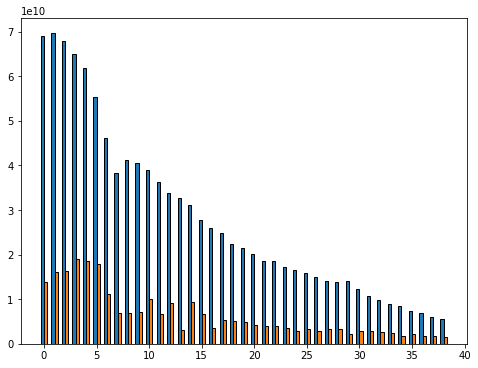

In [22]:
fig, ax = plt.subplots(1,1, figsize = (8,6))
x=np.arange(len(goog_quarter["Start Date"]))
width=0.3
rect1 = ax.bar(x - width/2,
              goog_quarter["Revenue"],
              width = width, 
               label = 2012,
               edgecolor = "black"
              )
rect2 = ax.bar(x + width/2,
              goog_quarter["Net Income/Loss"],
              width = width,
              label = 2013,
              edgecolor = "black")


In [77]:
#Create copy to rename columns to create boxplot for Anova calculation

aapl_box = aapl_yis.copy(deep=True)
amzn_box = amzn_yis.copy(deep=True)
goog_box = goog_yis.copy(deep=True)
aapl_box.rename(columns = {'Revenue':'AAPL Rev'}, inplace = True)
aapl_box.rename(columns = {'Net Income':'AAPL Net Income'}, inplace = True)
amzn_box.rename(columns = {'Revenue':'AMZN Rev'}, inplace = True)
amzn_box.rename(columns = {'Net Income':'AMZN Net Income'}, inplace = True)
goog_box.rename(columns = {'Revenue':'GOOG Rev'}, inplace = True)
goog_box.rename(columns = {'Net Income':'GOOG Net Income'}, inplace = True)
#aapl_box
aapl_box.drop([ "Date", "Period", "Filing Date", "Ticker", "Gross Profit", "EPS", "Shares Outstanding"], 1, inplace=True)
amzn_box.drop([ "Date", "Period", "Filing Date", "Ticker", "Gross Profit", "EPS", "Shares Outstanding"], 1, inplace=True)
goog_box.drop([ "Date", "Period", "Filing Date", "Ticker", "Gross Profit", "EPS", "Shares Outstanding"], 1, inplace=True)
amzn_box

,Fiscal Year,AMZN Rev,AMZN Net Income
0,2021,469822000000,33364000000
1,2020,386064000000,21331000000
2,2019,280522000000,11588000000
3,2018,232887000000,10073000000
4,2017,177866000000,3033000000
5,2016,135987000000,2371000000
6,2015,107006000000,596000000
7,2014,88988000000,-241000000
8,2013,74452000000,274000000
9,2012,61093000000,-39000000


In [136]:
box_plot_merge = aapl_box.merge(amzn_box, on="Fiscal Year", how='left')
box_plot_merge = box_plot_merge.merge(goog_box, on="Fiscal Year", how="left")
box_plot_rev = box_plot_merge.copy(deep=True)
box_plot_rev.drop([ "AMZN Net Income", "AAPL Net Income", "GOOG Net Income"], 1, inplace=True)

box_plot_merge.drop([ "AAPL Rev", "AMZN Rev", "GOOG Rev"], 1, inplace=True)
box_plot_merge = box_plot_merge.dropna()
box_plot_rev = box_plot_rev.dropna()
box_plot_rev2 = box_plot_rev.copy(deep=True)
box_plot_merge2 = box_plot_merge.copy(deep=True)
print(box_plot_rev)
print(box_plot_merge)

   Fiscal Year      AAPL Rev      AMZN Rev      GOOG Rev
1         2021  365817000000  469822000000  257637000000
2         2020  274515000000  386064000000  182527000000
3         2019  260174000000  280522000000  161857000000
4         2018  265595000000  232887000000  136819000000
5         2017  229234000000  177866000000  110855000000
6         2016  215639000000  135987000000   90272000000
7         2015  233715000000  107006000000   74989000000
8         2014  182795000000   88988000000   66001000000
9         2013  170910000000   74452000000   59825000000
10        2012  156508000000   61093000000   50175000000
11        2011  108249000000   48077000000   37905000000
   Fiscal Year AAPL Net Income AMZN Net Income GOOG Net Income
1         2021     94680000000     33364000000     76033000000
2         2020     57411000000     21331000000     40269000000
3         2019     55256000000     11588000000     34343000000
4         2018     59531000000     10073000000     30736000000
5

In [137]:
#Redo the format of the boxplot dataframes to better fit the boxplot info
box_plot_merge = pd.melt(box_plot_merge, id_vars='Fiscal Year', value_vars=['AAPL Net Income', 'AMZN Net Income', 'GOOG Net Income'])

box_plot_rev=pd.melt(box_plot_rev, id_vars="Fiscal Year", value_vars=["AAPL Rev", "AMZN Rev","GOOG Rev"])



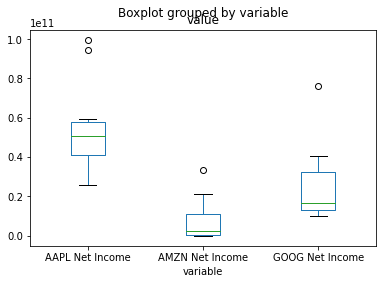

In [92]:
#Create boxplot for Net Income 
box_plot_merge.boxplot(by ='variable', column =['value'], grid = False)

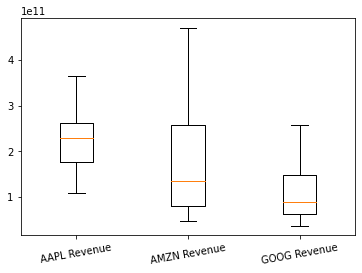

In [142]:
aapl_rev = box_plot_rev2["AAPL Rev"]
amzn_rev = box_plot_rev2["AMZN Rev"]
goog_rev = box_plot_rev2["GOOG Rev"]
columns = [aapl_rev, amzn_rev, goog_rev]
fig, ax = plt.subplots()
ax.boxplot(columns)
plt.xticks([1, 2, 3], ["AAPL Revenue", "AMZN Revenue", "GOOG Revenue"], rotation=10)
plt.show()


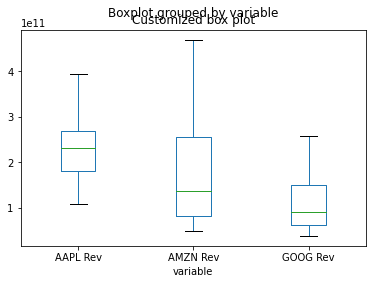

In [132]:
box_plot_rev.boxplot(by ='variable', column =['value'], grid = False)


In [98]:
#Extract individual revenues
aapl_rev = box_plot_rev[box_plot_rev["variable"] == "AAPL Rev"]["value"]
amzn_rev = box_plot_rev[box_plot_rev["variable"] == "AMZN Rev"]["value"]
goog_rev = box_plot_rev[box_plot_rev["variable"] == "GOOG Rev"]["value"]
#calculate anova for Revenue
stats.f_oneway(aapl_rev, amzn_rev, goog_rev)

F_onewayResult(statistic=4.516061880858602, pvalue=0.019000825922677406)

In [99]:
#Extract individual revenues
aapl_net = box_plot_merge[box_plot_merge["variable"] == "AAPL Net Income"]["value"]
amzn_net = box_plot_merge[box_plot_merge["variable"] == "AMZN Net Income"]["value"]
goog_net = box_plot_merge[box_plot_merge["variable"] == "GOOG Net Income"]["value"]
#calculate anova for Revenue
stats.f_oneway(aapl_net, amzn_net, goog_net)

F_onewayResult(statistic=19.638264149500845, pvalue=3.094187452296735e-06)